<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# STAT542: Statistical Learning

## Final Project ##

* Yu-Ching Liao <ycliao3@illinois.edu>

# Basic Import

In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, NMF, KNNWithMeans
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Reading Data

In [2]:
# Load the data
csv_data = pd.read_csv("Training_set.csv")
display(csv_data.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,NaN,3.0,NaN,3.0,NaN,3.0,5.0,NaN,3.0,4.0,NaN,5.0,5.0,3.0,NaN
1,4.0,NaN,5.0,5.0,2.0,NaN,1.0,NaN,4.0,NaN,NaN,5.0,NaN,5.0,3.0
2,3.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,1.0,3.0,NaN,4.0,3.0,NaN,3.0
3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,3.0,NaN,NaN,2.0,NaN
4,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,3.0,4.0,NaN,NaN,2.0,NaN


μ: 3.420253164556962
σ: 0.9914035245882147


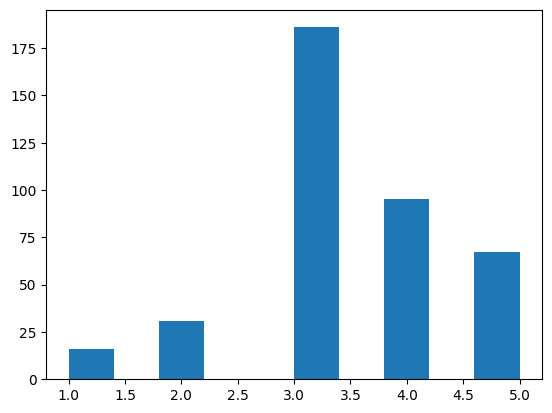

In [3]:
l = []
for i in csv_data.index:
    #print(csv_data.loc[i])
    for j in csv_data.columns:
        #print(csv_data.loc[i][j])
        if not pd.isna(csv_data.loc[i][j]): 
            l.append(csv_data.loc[i][j])
print("μ:", np.mean(l))
print("σ:", np.std(l))

plt.hist(l, bins=10)
plt.show()

# Algorithm

## K-Nearest Neighbors (KNN)

### Get Best K

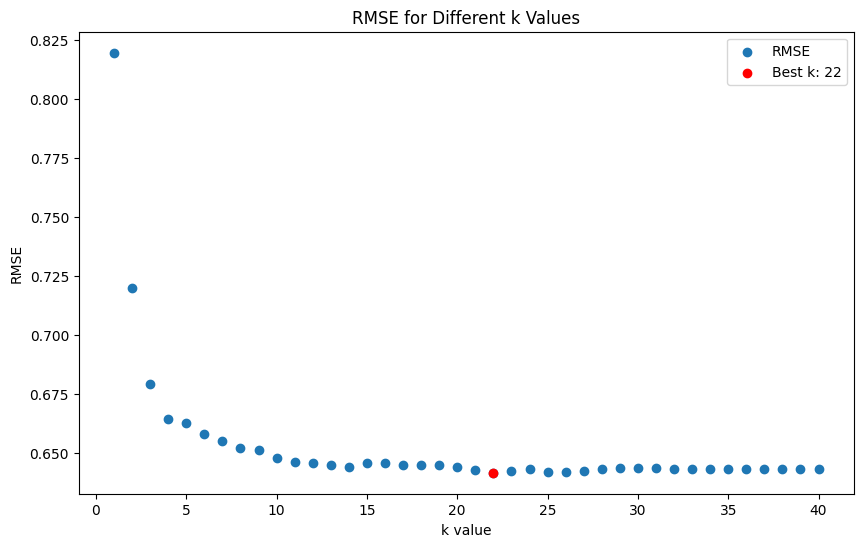

The best k value is: 22.
The Mean Squared Error (MSE) is: 0.4115700362249438
The Root Mean Squared Error (RMSE) is: 0.6415372446124572
The Mean Absolute Error (MAE) is: 0.34583770220411375
The Mean Absolute Percentage Error (MAPE) is: 0.10130674048169104%


In [4]:
# Transform the data into a list of tuples (user_id, video_id, rating)
data = [
    (user_id, video_id, rating)
    for user_id, row in csv_data.iterrows()
    for video_id, rating in enumerate(row, start=1)
    if not pd.isna(rating)
]

# Define the reader to specify the rating_scale
reader = Reader(rating_scale=(1, 5))

# Create the dataset
dataset = Dataset.load_from_df(pd.DataFrame(data, columns=["user_id", "video_id", "rating"]), reader)

# Load the answer.csv file
answer_data = pd.read_csv("Answers.csv")

# Define the range of k values to try
k_values = list(range(1, 41))

# Initialize variables to store the best k and the lowest RMSE
best_k = None
lowest_rmse = float('inf')

# Initialize a list to store RMSE values for each k
rmse_values = []

for k in k_values:
    # Train the KNNWithMeans algorithm with the current k value
    knn = KNNWithMeans(k=k, verbose=False)
    trainset = dataset.build_full_trainset()
    knn.fit(trainset)

    # Fill the missing values in the dataset
    filled_data = csv_data.copy()
    for user_id, row in csv_data.iterrows():
        for video_id, rating in enumerate(row, start=1):
            if pd.isna(rating):
                prediction = knn.predict(user_id, video_id)
                filled_data.at[user_id, f'V{video_id}'] = prediction.est

    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(MSE(filled_data, answer_data))
    rmse_values.append(rmse)

    # Update the best k and the lowest RMSE if the current RMSE is lower than the previous lowest RMSE
    if rmse < lowest_rmse:
        best_k = k
        lowest_rmse = rmse
        lowest_mse = MSE(filled_data, answer_data)
        lowest_mae = MAE(filled_data, answer_data)
        lowest_mape = MAPE(filled_data, answer_data)

# Plot the RMSE values for each k
plt.figure(figsize=(10, 6))
plt.scatter(k_values, rmse_values, label='RMSE')
plt.scatter(best_k, lowest_rmse, color='red', label=f'Best k: {best_k}')

# Add labels and a legend
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.title('RMSE for Different k Values')
plt.legend()

# Show the plot
plt.show()


print(f"The best k value is: {best_k}.")
print(f"The Mean Squared Error (MSE) is: {lowest_mse}")
print(f"The Root Mean Squared Error (RMSE) is: {lowest_rmse}")
print(f"The Mean Absolute Error (MAE) is: {lowest_mae}")
print(f"The Mean Absolute Percentage Error (MAPE) is: {lowest_mape}%")


### Simply Taking Average

In [5]:
training_data = pd.read_csv("Training_set.csv")
mean_value = training_data.stack().mean()
print("μ:", mean_value)
filled_with_mean = training_data.fillna(mean_value)

# Calculate the mean squared error (MSE)
mse = MSE(filled_with_mean, answer_data)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE)
mae = MAE(filled_with_mean, answer_data)

# Calculate the mean absolute percentage error (MAPE)
mape = MAPE(filled_with_mean, answer_data)

print(f"The Mean Squared Error (MSE) is: {mse}")
print(f"The Root Mean Squared Error (RMSE) is: {rmse}")
print(f"The Mean Absolute Error (MAE) is: {mae}")
print(f"The Mean Absolute Percentage Error (MAPE) is: {mape}%")

μ: 3.420253164556962
The Mean Squared Error (MSE) is: 0.4313401484804786
The Root Mean Squared Error (RMSE) is: 0.6567649111215356
The Mean Absolute Error (MAE) is: 0.36996793248945153
The Mean Absolute Percentage Error (MAPE) is: 0.10816975080187514%


# Storage

In [6]:
"""# Function to recommend videos
def recommend_videos(user_id, n_recommendations=5):
    video_ids = set(range(1, 16))  # Assuming 15 videos
    rated_videos = {entry[1] for entry in data if entry[0] == user_id}
    not_rated_videos = video_ids - rated_videos

    # Predict the ratings for the not-rated videos
    predictions = [(video_id, knn.predict(user_id, video_id).est) for video_id in not_rated_videos]

    # Sort the predictions by estimated rating (descending order) and get the top n_recommendations
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    return [f"Recommended Video: V{rec[0]}, Score: {rec[1]:.5f}" for rec in recommendations]

# Get recommendations for all users
user_ids = csv_data.index.unique().tolist()
all_recommendations = [recommend_videos(user_id) for user_id in user_ids]

# Create a DataFrame with recommendations
recommendations_df = pd.DataFrame(all_recommendations, columns=[f'Rec_{i+1}' for i in range(5)], index=user_ids)
recommendations_df.index.name = 'user_id'

print("\nRecommendations for all users:")
display(recommendations_df)"""

'# Function to recommend videos\ndef recommend_videos(user_id, n_recommendations=5):\n    video_ids = set(range(1, 16))  # Assuming 15 videos\n    rated_videos = {entry[1] for entry in data if entry[0] == user_id}\n    not_rated_videos = video_ids - rated_videos\n\n    # Predict the ratings for the not-rated videos\n    predictions = [(video_id, knn.predict(user_id, video_id).est) for video_id in not_rated_videos]\n\n    # Sort the predictions by estimated rating (descending order) and get the top n_recommendations\n    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]\n\n    return [f"Recommended Video: V{rec[0]}, Score: {rec[1]:.5f}" for rec in recommendations]\n\n# Get recommendations for all users\nuser_ids = csv_data.index.unique().tolist()\nall_recommendations = [recommend_videos(user_id) for user_id in user_ids]\n\n# Create a DataFrame with recommendations\nrecommendations_df = pd.DataFrame(all_recommendations, columns=[f\'Rec_{i+1}\' fo

<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>